# Backtesting pipeline
Date : 2024/11/01

This notebook contains backtesting on inference done on batch : 2024-11-01

In [1]:
import os 

current_dir = os.getcwd()
project_name = "bcppmchurn"
general_dir =  os.path.join(current_dir.split(project_name)[0], project_name)
os.chdir(general_dir)
os.getcwd()

'/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import random
from datetime import datetime
from ipywidgets import interact, FloatRangeSlider, fixed

from src.eda import utils
import importlib
importlib.reload(utils)
from src.eda import utils 

### Back test

Load data

In [3]:
data_date = '2024-12-23' 
dns_churn = pd.read_csv (f"data/output_data/{data_date}_dns_churn.csv", index_col=0)
x_norm = pd.read_csv(f"data/inference_data/{data_date}_x_norm.csv", index_col=0)
dns = pd.read_csv(f"data/inference_data/{data_date}_dns.csv")

In [4]:
dns_churn.head()

,dn,churn_segment,churn_prediction_score
0,212603971703,non_churner,0.328880
1,212707542311,non_churner,0.247322
2,212608768406,non_churner,0.457917
3,212615364402,non_churner,0.332615
4,212702254606,non_churner,0.253287


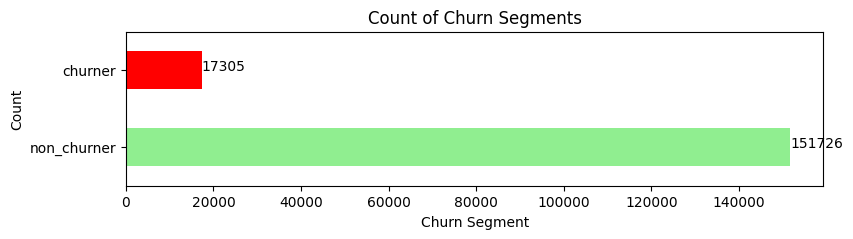

In [5]:
utils.vis_count_target_segment(dns_churn["churn_segment"])

Text(0.5, 1.0, 'Count of prediction scores')

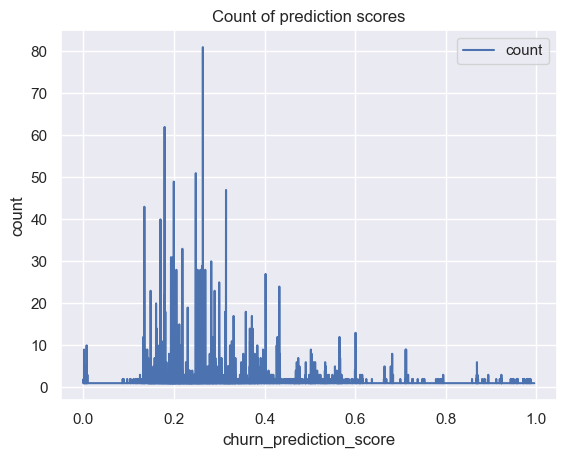

In [6]:
count_score = dns_churn["churn_prediction_score"].value_counts()
count_score = pd.DataFrame (count_score)
sns.set_theme()
sns.lineplot( data = count_score )
plt.xlabel("churn_prediction_score")
plt.ylabel("count")
plt.title("Count of prediction scores")

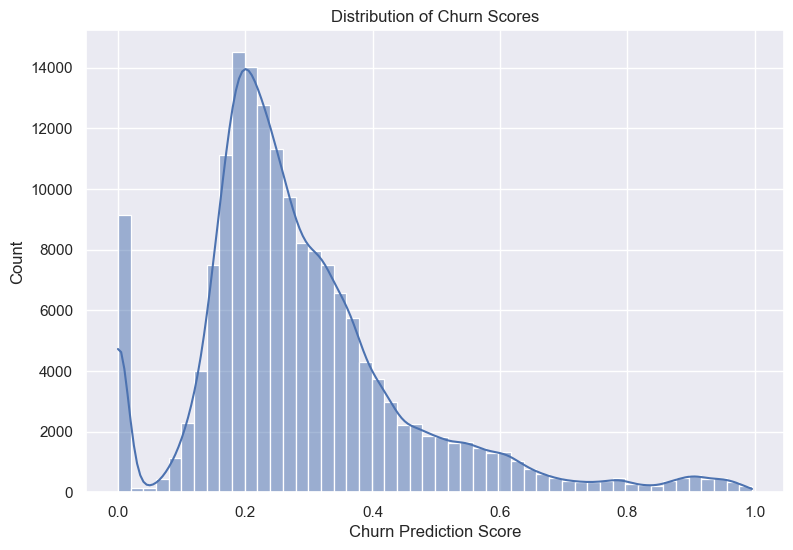

In [7]:
#Distribution of churn score
plt.figure(figsize=(9, 6))
sns.histplot(data=dns_churn, x='churn_prediction_score', bins=50, kde=True)
plt.title('Distribution of Churn Scores')
plt.xlabel('Churn Prediction Score')
plt.ylabel('Count')
plt.show()

In [ ]:
#Distribution of churn score for only churners 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7*2, 5))
ax = ax.flatten()
sns.histplot(data=dns_churn[dns_churn["churn_segment"] == "non_churner"], x='churn_prediction_score', bins=40, kde=True, color="lightgreen", ax=ax[0], label = "non churners")
sns.histplot(data=dns_churn[dns_churn["churn_segment"] == "churner"], x='churn_prediction_score', bins=40, kde=True, color="red", ax=ax[1], label = "churners")
plt.title('Distribution of Churn Scores only for churners')
plt.xlabel('Churn Prediction Score')
ax[0].set_ylabel("Count non churners")
ax[0].set_title("Distribution of churn score for non churners")
ax[0].legend()
ax[1].set_ylabel("Count churners")
ax[1].set_title("Distribution of churn score for churners")
ax[1].legend()
plt.show()

In [ ]:
#Cumulative score 
sorted_scores = dns_churn['churn_prediction_score'].sort_values()
cumulative = sorted_scores.cumsum() / sorted_scores.sum()
plt.plot(range(len(sorted_scores)), cumulative)
plt.title('Cumulative Churn score')
plt.xlabel('Client Rank')
plt.ylabel('Cumulative Churn Score')
plt.show()

In [ ]:
with open("models/ml_models/2024-10-25_xgb_model.pkl", "rb") as f:
    MODEL = pickle.load(f)

In [ ]:
#the SHAP explainer
explainer = shap.TreeExplainer(MODEL)
#Calculate SHAP values for the feature data
shap_values = explainer(x_norm)

dn                        212600000006
churn_segment              non_churner
churn_prediction_score        0.050082
Name: 0, dtype: object
         --------------------
dn                        212600019900
churn_segment              non_churner
churn_prediction_score        0.020007
Name: 100, dtype: object
        ----------------------
dn                        212600093306
churn_segment                  churner
churn_prediction_score        0.811963
Name: 305, dtype: object
        ----------------------
dn                        212779004911
churn_segment                  churner
churn_prediction_score        0.664804
Name: 230029, dtype: object

In [ ]:
#Shap values for sample 0
sample_index = 0 #non churner 
shap.plots.waterfall(shap_values[sample_index], max_display = 30)

In [ ]:
#Shap values for sample 0
sample_index = 100 #non churner 
shap.plots.waterfall(shap_values[sample_index], max_display = 30)
#payement_invoice_status_open_open_amount_sum_value_1_2

In [ ]:
dns_churn = dns_churn.reset_index(drop = True)

In [ ]:
#Shap values for sample 0
sample_index = 11 #churner 
shap.plots.waterfall(shap_values[sample_index], max_display = 30)

In [ ]:
#Shap values for sample 0
sample_index = 168911 #churner 
shap.plots.waterfall(shap_values[sample_index], max_display = 30)

In [ ]:
shap.summary_plot(shap_values, x_norm, plot_size= [14, 9])

In [ ]:
#Get shap values by explainer.shap_values
old_shap_values =  explainer.shap_values(x_norm)

In [ ]:
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
# Sort features by mean absolute SHAP value in descending order
ordered_features = x_norm.columns[np.argsort(-mean_abs_shap_values)]
# Display ordered features as a list
ordered_features_by_shape_values = ordered_features.tolist()
nrows =20
fig, axes = plt.subplots(nrows = nrows//2, ncols = 2, figsize=(2*8, 5*(nrows//2)))
axes = axes.flatten()
for i, feature in enumerate (ordered_features_by_shape_values[:nrows]):
    shap.dependence_plot(feature, old_shap_values, x_norm, ax=axes[i], show=False)
plt.tight_layout()
plt.show()

### Compare model outputs with acctual data 

In [8]:
#Loading actual data 
batch_date = "2024-11-01"
actual_data = pd.read_excel(f"data/real_data/{batch_date}_results.xlsx")
actual_data.head()

,id,dn,churn_segment,churn_prediction_score,v_cancellation_date,v_expiration_date,suspension_date,Range churn,Date churn
0,16,212603971703,non_churner,0.020271,NaN,NaN,NaN,score <90,Client actif
1,17,212707542311,non_churner,0.012605,NaN,NaN,NaN,score <90,Client actif
2,19,212608768406,non_churner,0.043119,NaN,NaN,NaN,score <90,Client actif
3,20,212615364402,non_churner,0.016593,NaN,NaN,NaN,score <90,Client actif
4,37,212702254606,non_churner,0.020904,NaN,NaN,NaN,score <90,Client actif


In [9]:
actual_data["churn_segment"], actual_data["churn_prediction_score"] = dns_churn["churn_segment"], dns_churn["churn_prediction_score"] 

In [10]:
mdn_to_delete = actual_data[actual_data["Date churn"] == "2024/10/18"].index
actual_data.drop(index=mdn_to_delete, inplace=True)

In [11]:
actual_data["Date churn"].unique() 

array(['Client actif', '2024/11/11', '2024/11/22', '2024/11/27',
       '2024/11/23', '2024/11/14', '2024/11/10', '2024/11/07',
       '2024/11/21', '2024/11/12', '2024/11/13', '2024/11/24',
       '2024/11/29', '2024/11/02', '2024/11/04', '2024/11/20',
       '2024/11/17', '2024/11/16', '2024/11/15', '2024/11/03',
       '2024/12/04', '2024/11/06', '2024/11/08', '2024/11/30',
       '2024/11/28', '2024/11/18', '2024/11/09', '2024/11/05',
       '2024/11/25', '2024/11/19', '2024/11/26', '2024/12/02',
       '2024/12/01', '2024/12/03', '2024/11/01'], dtype=object)

In [12]:
#Add actual_churn_segment column
actual_churn_segment = ["non_churner" if value=="Client actif" else "churner" for value in actual_data["Date churn"]]
actual_data["actual_churn_segment"] = actual_churn_segment
#Transfomr churn_segment to an int
churn_mapping = {"non_churner": 0, "churner" : 1}
actual_data["churn_segment_"] = actual_data["churn_segment"].map(churn_mapping) 
actual_data["actual_churn_segment_"] = actual_data["actual_churn_segment"].map(churn_mapping) 
actual_data.head()

,id,dn,churn_segment,churn_prediction_score,v_cancellation_date,v_expiration_date,suspension_date,Range churn,Date churn,actual_churn_segment,churn_segment_,actual_churn_segment_
0,16,212603971703,non_churner,0.328880,NaN,NaN,NaN,score <90,Client actif,non_churner,0,0
1,17,212707542311,non_churner,0.247322,NaN,NaN,NaN,score <90,Client actif,non_churner,0,0
2,19,212608768406,non_churner,0.457917,NaN,NaN,NaN,score <90,Client actif,non_churner,0,0
3,20,212615364402,non_churner,0.332615,NaN,NaN,NaN,score <90,Client actif,non_churner,0,0
4,37,212702254606,non_churner,0.253287,NaN,NaN,NaN,score <90,Client actif,non_churner,0,0


Predicted results


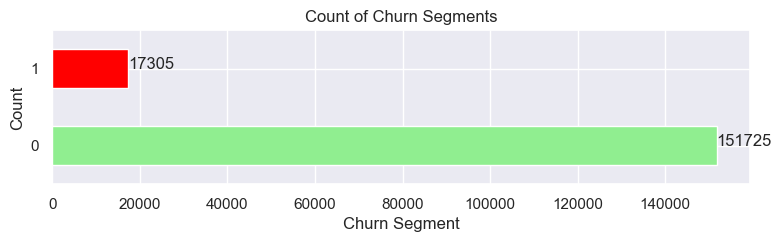

Actual results


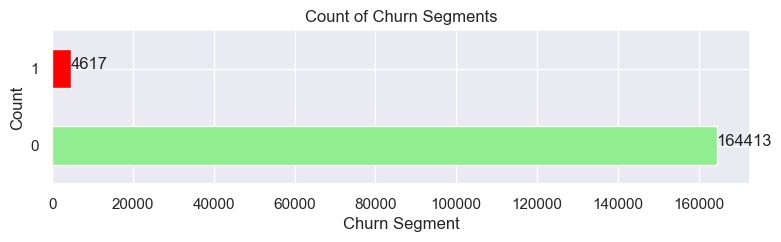

In [13]:
print ("Predicted results")
utils.vis_count_target_segment(actual_data["churn_segment_"])
print ("Actual results")
utils.vis_count_target_segment(actual_data["actual_churn_segment_"])

           test set         
------------------------------------------------------------
 accuracy      : 0.8930485712595397
 precision     : 0.1110661658480208
 recall        : 0.41628763266190166
 f1 score      : 0.17534896451053736
 roc_auc_score : 0.6613622357989978
-------------------------------------------------------------


/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/src/eda/utils.py:291: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


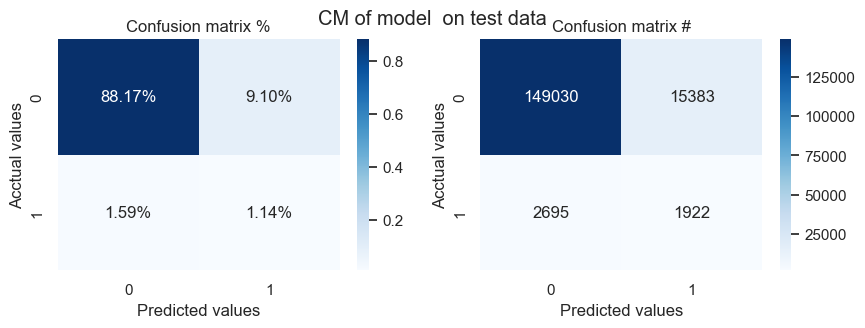

In [14]:
utils.report_model_performances(actual_data["actual_churn_segment_"],
                                actual_data["churn_segment_"], 
                                details=False)

<Axes: title={'center': 'Number of mistakes and correct score predictions by range'}, xlabel='Score ranges', ylabel='Score count'>

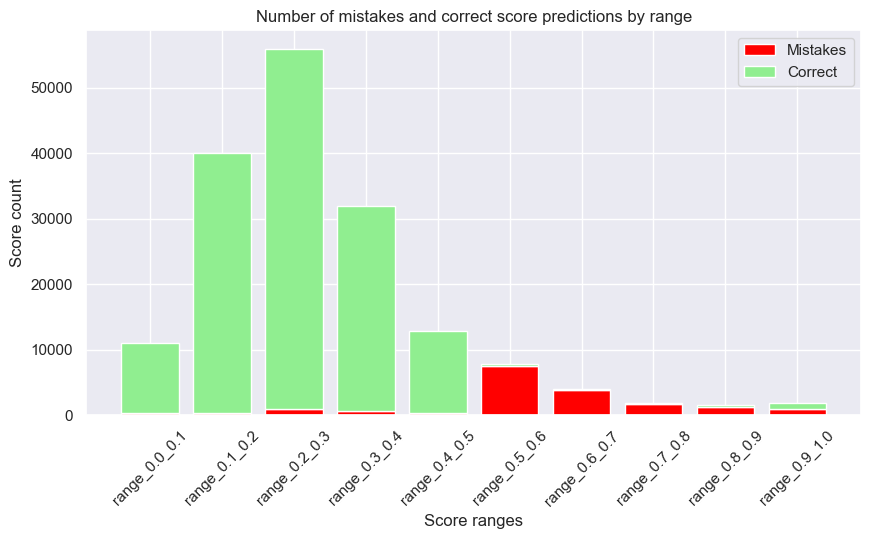

In [15]:
utils.vis_count_mistakes_and_correct_scores(actual_data["actual_churn_segment_"], 
                                            actual_data["churn_segment_"], 
                                            actual_data["churn_prediction_score"], 
                                             figsize=(10, 5))

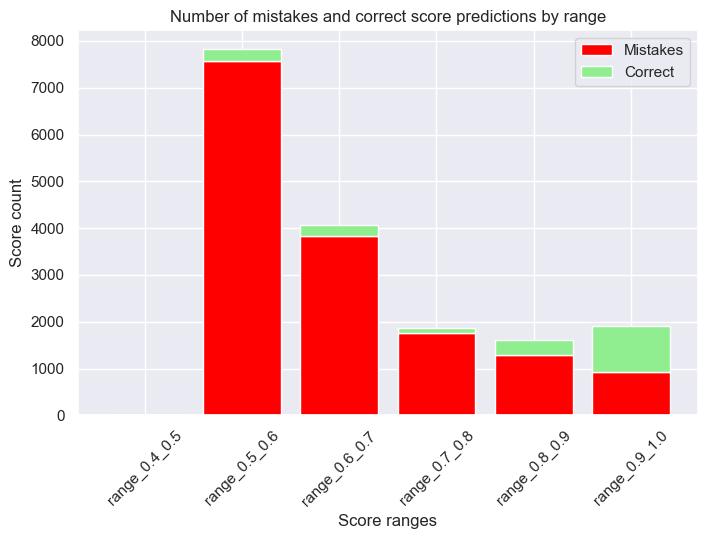

In [16]:
predicted_churners = actual_data [actual_data["churn_segment_"] == 1]
range = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ]
utils.vis_count_mistakes_and_correct_scores(predicted_churners["actual_churn_segment_"], 
                                            predicted_churners["churn_segment_"], 
                                            predicted_churners["churn_prediction_score"], 
                                            range_=range, figsize=(8, 5))
plt.show()

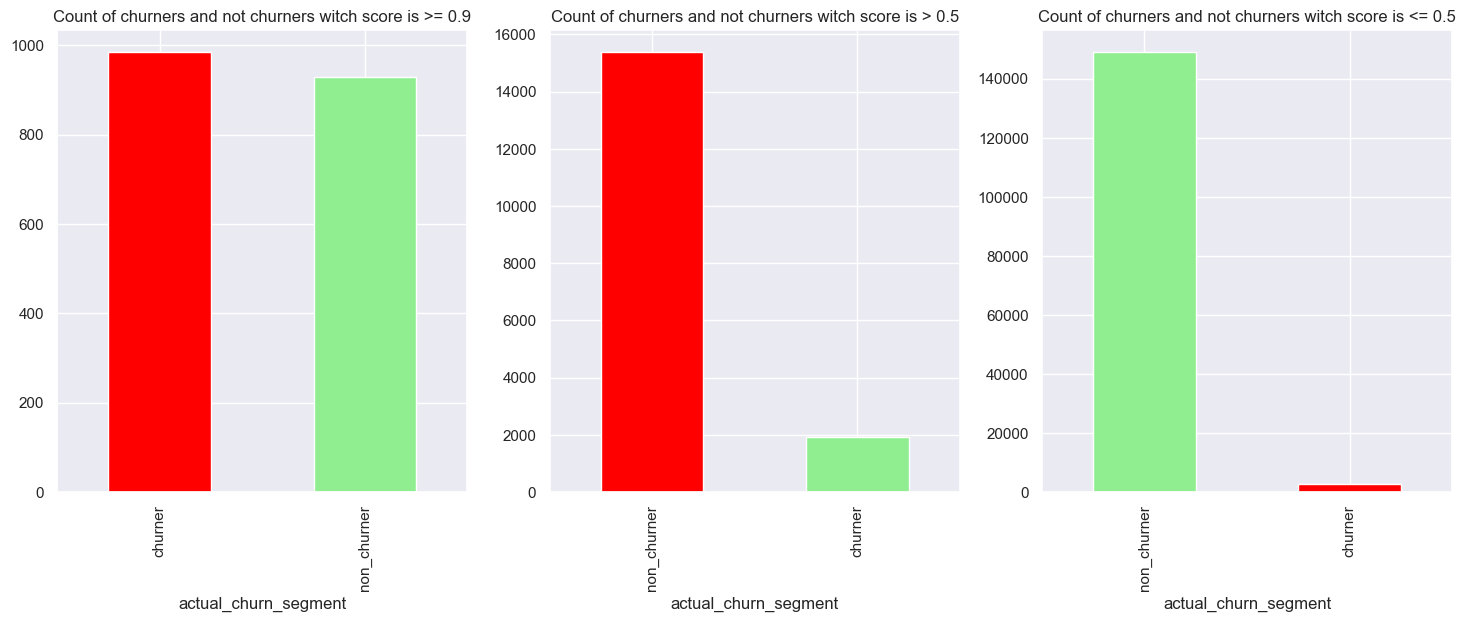

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(6*3, 6))
ax = ax.flatten()
score_greater_than_0_9 =  actual_data[actual_data["churn_prediction_score"]>= 0.9 ]
score_greater_than_0_5 =  actual_data[actual_data["churn_prediction_score"]> 0.5 ]
score_less_than_0_5 =  actual_data[actual_data["churn_prediction_score"] <= 0.5 ]
score_greater_than_0_9["actual_churn_segment"].value_counts().plot(kind="bar", ax=ax[0], color=["red", "lightgreen"])
score_greater_than_0_5["actual_churn_segment"].value_counts().plot(kind="bar", ax=ax[1], color=["red", "lightgreen"])
score_less_than_0_5["actual_churn_segment"].value_counts().plot(kind="bar", ax=ax[2], color=["lightgreen", "red"])
ax[0].set_title(f"Count of churners and not churners witch score is >= 0.9")
ax[1].set_title(f"Count of churners and not churners witch score is > 0.5")
ax[2].set_title(f"Count of churners and not churners witch score is <= 0.5")
plt.show()

/var/folders/2q/gyy3wtmd6_b1bxmlfb4j1dvh0000gp/T/ipykernel_65852/1701292268.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


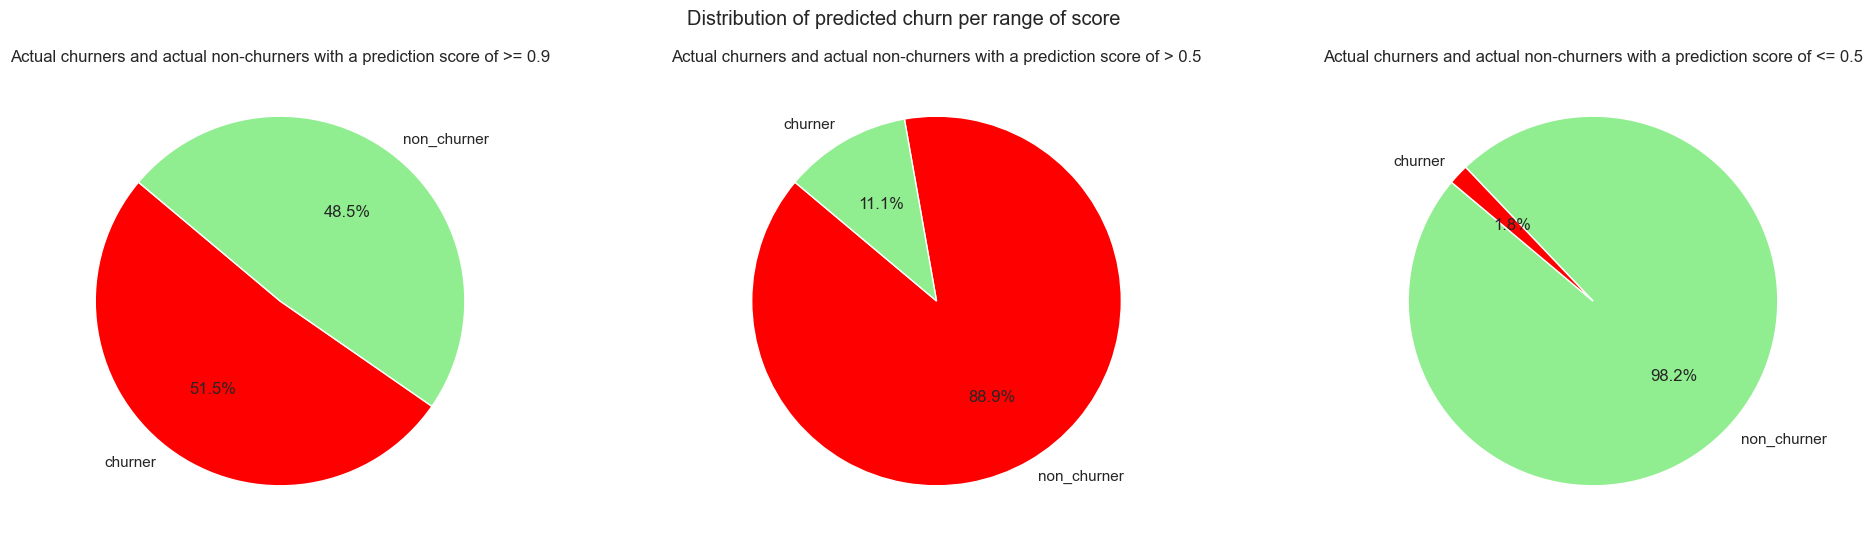

In [29]:
#Scores 
sns.set_theme()
score_greater_than_0_9 =  actual_data[actual_data["churn_prediction_score"]>= 0.9 ]
score_greater_than_0_5 =  actual_data[actual_data["churn_prediction_score"]> 0.5 ]
score_less_than_0_5 =  actual_data[actual_data["churn_prediction_score"] <= 0.5 ]
#Figures
fig, axes = plt.subplots(nrows = 1, ncols=3, figsize=(8*3, 6) )
axes = axes.flatten()
percentage_0_9 = score_greater_than_0_9["actual_churn_segment"].value_counts(normalize=True)*100
percentage_sup_0_5 = score_greater_than_0_5["actual_churn_segment"].value_counts(normalize=True)*100
percentage_inf_0_5 = score_less_than_0_5["actual_churn_segment"].value_counts(normalize=True)*100

axes[0].pie(percentage_0_9, labels = percentage_0_9.index, autopct='%1.1f%%', startangle=140, colors = ["red", "lightgreen"])
axes[1].pie(percentage_sup_0_5.tolist(), labels=percentage_sup_0_5.index, autopct='%1.1f%%', startangle=140, colors = ["red", "lightgreen"])
axes[2].pie(percentage_inf_0_5.tolist(), labels=percentage_inf_0_5.index, autopct='%1.1f%%', startangle=140, colors = ["lightgreen", "red"])

#titles 
axes[0].set_title(f"Actual churners and actual non-churners with a prediction score of >= 0.9")
axes[1].set_title(f"Actual churners and actual non-churners with a prediction score of > 0.5")
axes[2].set_title(f"Actual churners and actual non-churners with a prediction score of <= 0.5")
fig.suptitle("Distribution of predicted churn per range of score ")
fig.show()

- 86% of mdns predicted to churn with a score higher than 0.9 indeed churned
- 57% of mnds predicted to churn with a score higher than 0.5 indeed churned
- 98% of mdns predicted to stay with a score less than 0.5 ideed remain actif

**Let's Visualize the score ranges of each type of mdns (TP, FP, TN, FN)**

In [30]:
#Get TP, FP, TN and FN mdns
TP = actual_data[(actual_data["churn_segment"] == "churner") & (actual_data["actual_churn_segment"]=="churner")]
FP = actual_data[(actual_data["churn_segment"] == "churner") & (actual_data["actual_churn_segment"]=="non_churner")]
TN = actual_data[(actual_data["churn_segment"] == "non_churner") & (actual_data["actual_churn_segment"]=="non_churner")]
FN = actual_data[(actual_data["churn_segment"] == "non_churner") & (actual_data["actual_churn_segment"]=="churner")]

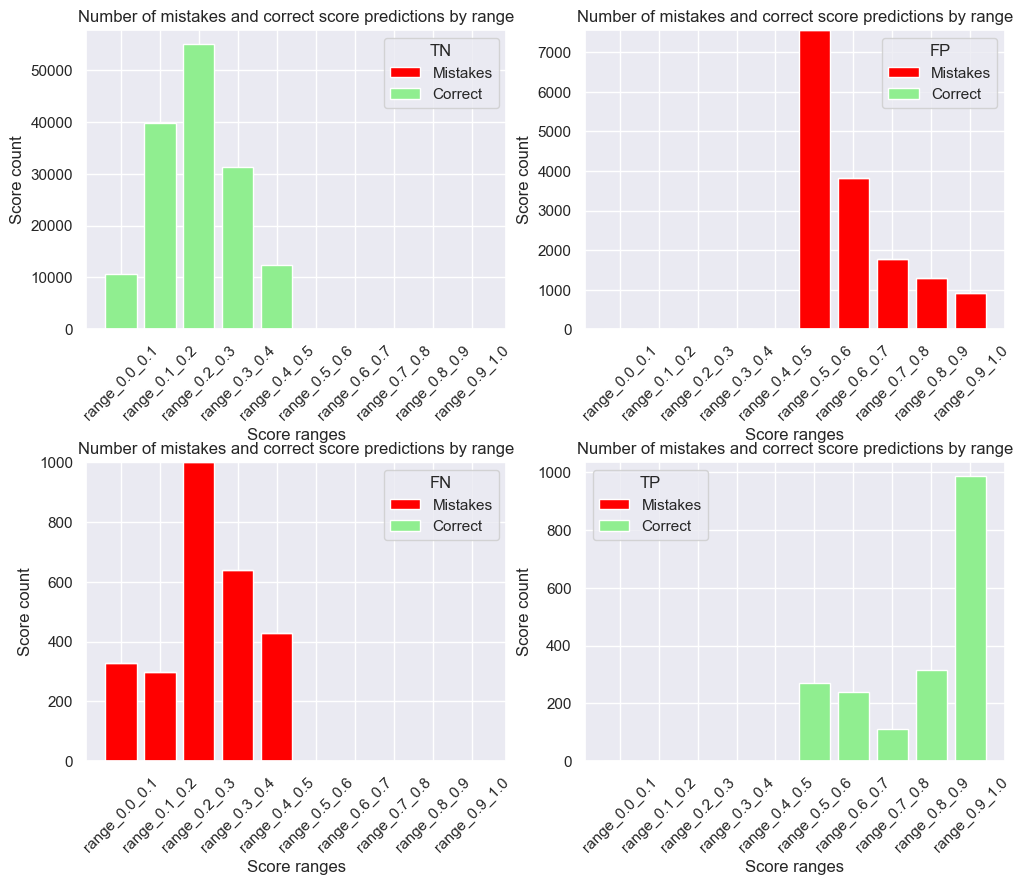

In [31]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (5*2, 4*2))
axes = axes.flatten()
plt.tight_layout(w_pad = 2, h_pad = 6)
#TN
utils.vis_count_mistakes_and_correct_scores(TN["actual_churn_segment_"], 
                                            TN["churn_segment_"], 
                                            TN["churn_prediction_score"], 
                                            ax = axes[0],
                                            title = "TN"
                                            )
#FP
utils.vis_count_mistakes_and_correct_scores(FP["actual_churn_segment_"], 
                                            FP["churn_segment_"], 
                                            FP["churn_prediction_score"], 
                                            ax = axes[1],
                                            title = "FP"
                                            )
#FN
utils.vis_count_mistakes_and_correct_scores(FN["actual_churn_segment_"], 
                                            FN["churn_segment_"], 
                                            FN["churn_prediction_score"], 
                                            ax = axes[2],
                                            title = "FN"
                                            )
#TP
utils.vis_count_mistakes_and_correct_scores(TP["actual_churn_segment_"], 
                                            TP["churn_segment_"], 
                                            TP["churn_prediction_score"], 
                                            ax = axes[3],
                                            title = "TP"
                                            )
plt.show()

--------------------------

##################### ACTUAL CHURNERS ##########################


/var/folders/2q/gyy3wtmd6_b1bxmlfb4j1dvh0000gp/T/ipykernel_65852/1192012842.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_churn_count_17_30["cumulative_churners"] = real_churn_count_17_30["cumulative_churners"]


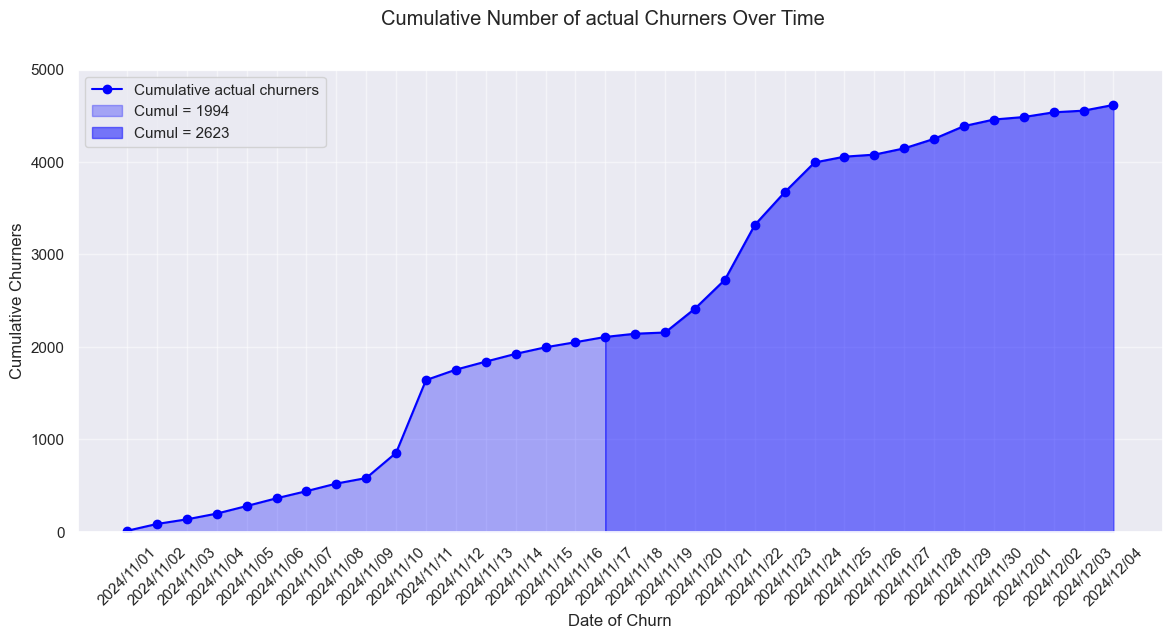

In [32]:
print ("##################### ACTUAL CHURNERS ##########################")
actula_churners = actual_data [actual_data["actual_churn_segment"] == "churner"]

# Group by churn date and count the number of churners per date
real_churn_count = actula_churners.groupby("Date churn").size().reset_index(name="daily_churners")

# Calculate the cumulative sum of churners
real_churn_count["cumulative_churners"] = real_churn_count["daily_churners"].cumsum()
real_churn_count_00_17 = real_churn_count[real_churn_count["Date churn"]<= "2024/11/17"]
real_churn_count_17_30 = real_churn_count[real_churn_count["Date churn"]>= "2024/11/17"]
real_churn_count_17_30["cumulative_churners"] = real_churn_count_17_30["cumulative_churners"]

real_cumul_00_17 = real_churn_count_00_17[real_churn_count_00_17["Date churn"] == "2024/11/15"]["cumulative_churners"].item()
real_cumul_17_30 = real_churn_count_17_30[real_churn_count_17_30["Date churn"] == "2024/12/04"]["cumulative_churners"].item()
#
fig, axes= plt.subplots(figsize=(14, 6))
# Plot the cumulative number of churners over time
#plt.figure()
axes.plot(real_churn_count["Date churn"], 
             real_churn_count["cumulative_churners"], 
             marker="o", linestyle="-", color="blue",
             label = "Cumulative actual churners"  )
axes.fill_between(
    real_churn_count_00_17["Date churn"], 
    real_churn_count_00_17["cumulative_churners"], 
    color="blue", alpha=0.3,
    label = f"Cumul = {real_cumul_00_17}"
)
axes.fill_between(real_churn_count_17_30["Date churn"], 
             real_churn_count_17_30["cumulative_churners"], 
             alpha=0.5, color = "blue",
             label = f"Cumul = {real_cumul_17_30 - real_cumul_00_17}"
             )

fig.suptitle("Cumulative Number of actual Churners Over Time")
axes.set_xlabel ("Date of Churn")
axes.tick_params(axis = "x", rotation = 45)
axes.set_ylabel("Cumulative Churners")
plt.grid(alpha=0.5)

#axes.annotate(f"{real_cumul_00_17}", ("2024/11/15", real_cumul_00_17-300))
#axes.annotate(f"{real_cumul_17_30}", ("2024/12/03", real_cumul_17_30-300))

axes.legend()
plt.ylim((0,5000))
plt.show()

Notice that at the begining of the month the number of churners increase slowely, there is tow remarquable augmentations : an increase of 1000 churners between days 09 and 10 and another of 2000 churners between 18 and 23

This pushes us to conclude 2 hypothesis: 
1. An action must be taken before day 18th in the month
2. Most of customers tend to churn by the end of the month, meaning another prediction should be done in the middle of the month

These hypothesis must be verified by the next months resutls 

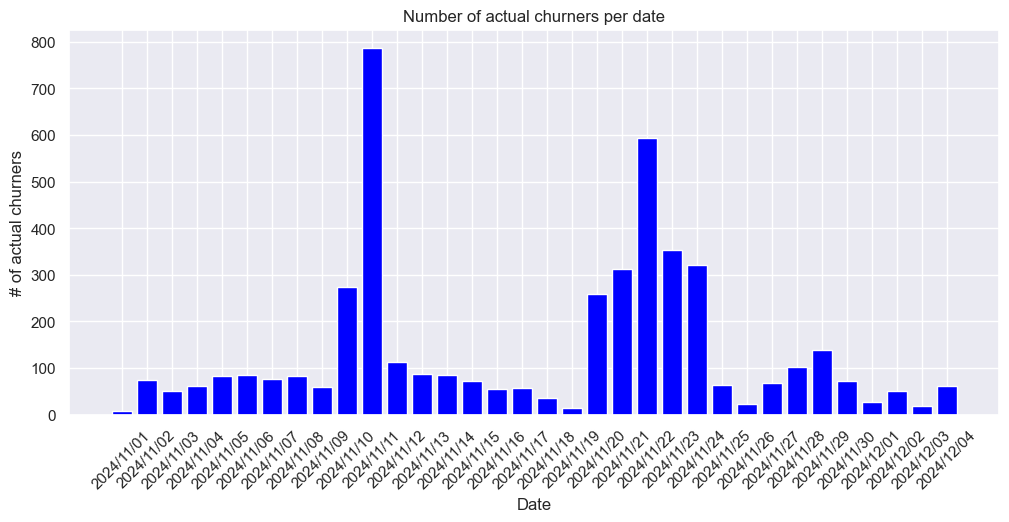

In [33]:
plt.figure(figsize=(12, 5))
plt.bar (real_churn_count["Date churn"], real_churn_count["daily_churners"], color = "blue")
plt.title("Number of actual churners per date")
plt.xlabel("Date")
plt.ylabel("# of actual churners")
plt.xticks (rotation = 45)
plt.show()

##################### Predicted  CHURNERS ##########################


/var/folders/2q/gyy3wtmd6_b1bxmlfb4j1dvh0000gp/T/ipykernel_65852/3447360625.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_churn_counts_17_30["cumulative_churners"] = predicted_churn_counts_17_30["cumulative_churners"]


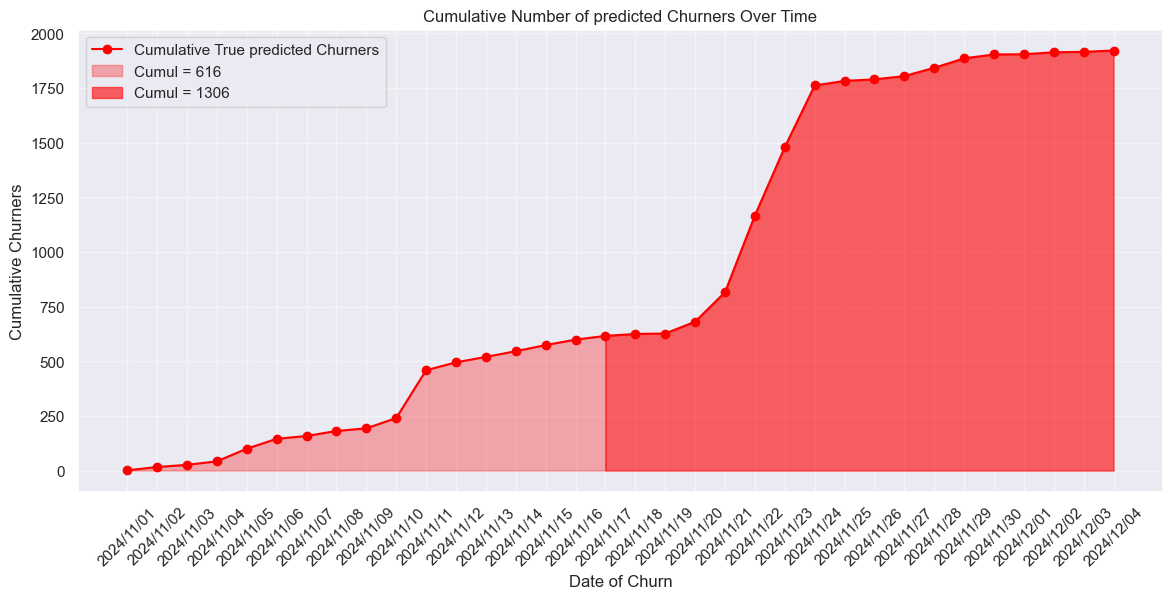

In [34]:
print ("##################### Predicted  CHURNERS ##########################")
predicted_churners = actual_data [(actual_data["churn_segment"] == "churner") & (actual_data["Date churn"] != "Client actif")]

# Group by churn date and count the number of churners per date
predicted_churn_counts = predicted_churners.groupby("Date churn").size().reset_index(name="daily_churners")

# Calculate the cumulative sum of churners
predicted_churn_counts["cumulative_churners"] = predicted_churn_counts["daily_churners"].cumsum()

predicted_churn_counts_00_17 = predicted_churn_counts[predicted_churn_counts["Date churn"] <= "2024/11/17"]
predicted_churn_counts_17_30 = predicted_churn_counts[predicted_churn_counts["Date churn"] >= "2024/11/17"]
predicted_churn_counts_17_30["cumulative_churners"] = predicted_churn_counts_17_30["cumulative_churners"]

predicted_cumul_00_17 = predicted_churn_counts_00_17[predicted_churn_counts_00_17["Date churn"] == "2024/11/17"]["cumulative_churners"].item()
predicted_cumul_17_30 = predicted_churn_counts_17_30[predicted_churn_counts_17_30["Date churn"] == "2024/12/04"]["cumulative_churners"].item()

fig, axes = plt.subplots(figsize=(14, 6))
# Plot the cumulative number of churners over time
axes.plot(predicted_churn_counts["Date churn"], 
          predicted_churn_counts["cumulative_churners"], 
          marker="o", linestyle="-", color="red", 
          label="Cumulative True predicted Churners"
          )
axes.fill_between(predicted_churn_counts_00_17["Date churn"], 
                  predicted_churn_counts_00_17["cumulative_churners"], 
                  alpha = 0.3, color = "red",
                  label = f"Cumul = {predicted_cumul_00_17}"
                  )
axes.fill_between(predicted_churn_counts_17_30["Date churn"], 
                  predicted_churn_counts_17_30["cumulative_churners"], 
                  alpha = 0.6, color = "red",
                  label = f"Cumul = {predicted_cumul_17_30 - predicted_cumul_00_17}"
                  )
plt.title("Cumulative Number of predicted Churners Over Time")
plt.xlabel("Date of Churn")
plt.xticks(rotation = 45)
plt.ylabel("Cumulative Churners")
plt.grid(alpha=0.5)
#plt.ylim((0, 5000))

#axes.annotate(f"{predicted_cumul_00_17}", ("2024/11/15", predicted_cumul_00_17-200))
#axes.annotate(f"{predicted_cumul_17_30}", ("2024/12/02", predicted_cumul_17_30-200))

plt.legend()
plt.show()

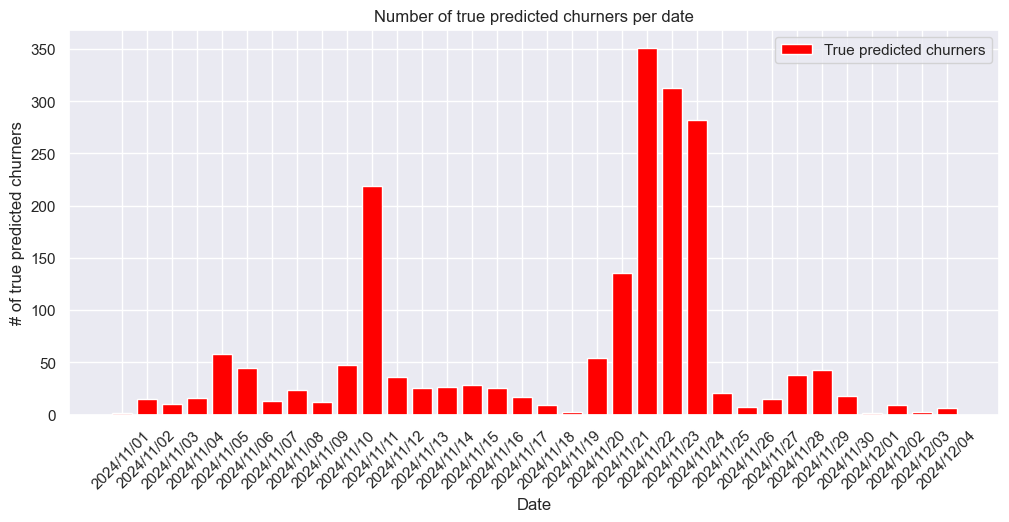

In [35]:
plt.figure(figsize=(12, 5))
plt.bar (predicted_churn_counts["Date churn"], predicted_churn_counts["daily_churners"], color = "red", label = "True predicted churners")
#plt.bar (predicted_false_churners_counts["Date churn"], predicted_false_churners_counts["daily_churners"], color = "blue", label = "false predicted non churners")
plt.title("Number of true predicted churners per date")
plt.xlabel("Date")
plt.ylabel("# of true predicted churners")
plt.xticks (rotation = 45)
plt.legend()
plt.show()

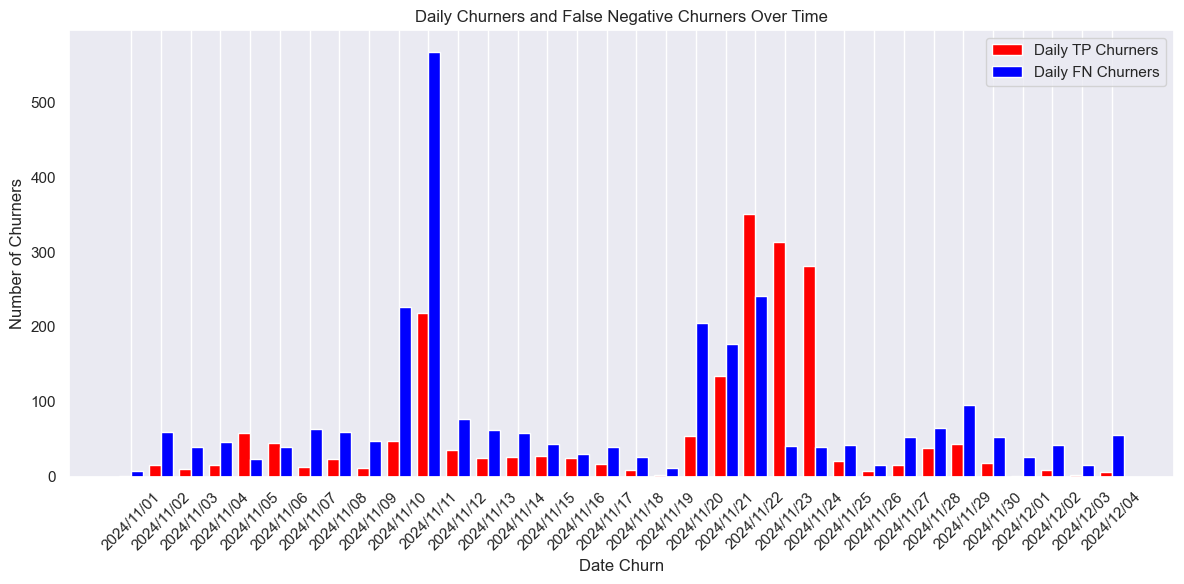

In [36]:
#mdns predicted to not churn but actually did churn : predicted_false_churners
predicted_false_non_churners = actual_data [(actual_data["churn_segment"] == "non_churner") & (actual_data["Date churn"] != "Client actif")]
predicted_false_churners_counts = predicted_false_non_churners.groupby("Date churn").size().reset_index(name = "daily_FN_churners")

daily_fn_and_tp = pd.merge(predicted_churn_counts, predicted_false_churners_counts, on="Date churn")

# Assuming daily_fn_and_tp is your DataFrame
x = np.arange(len(daily_fn_and_tp["Date churn"]))  # Numeric positions for bars

# Define bar width
bar_width = 0.4

plt.figure(figsize=(12, 6))

# Plot daily_churners
plt.bar(x - bar_width / 2, daily_fn_and_tp["daily_churners"], width=bar_width, label="Daily TP Churners", color="red")

# Plot daily_FN_churners
plt.bar(x + bar_width / 2, daily_fn_and_tp["daily_FN_churners"], width=bar_width, label="Daily FN Churners", color="blue")

# Add labels, title, and legend
plt.xlabel("Date Churn")
plt.ylabel("Number of Churners")
plt.title("Daily Churners and False Negative Churners Over Time")
plt.xticks(x, daily_fn_and_tp["Date churn"], rotation=45)  # Use dates as x-axis labels
plt.legend()
plt.grid(axis="y")

# Show the plot
plt.tight_layout()
plt.show()

Plot the same graph above by score ranges 

In [ ]:
def get_score_ranges(df, column_name):
    #Get score ranges column from churn score
    score_ranges = []
    for value in df[column_name]:
        if value > 0 and value <= 0.25:
            score_ranges.append("0__0.25")
        elif value > 0.25 and value <= 0.5:
            score_ranges.append("0.25__0.5")
        elif value > 0.5 and value <= 0.75:
            score_ranges.append("0.5__0.75")
        else:
            score_ranges.append("0.75__1")
    df["score_ranges"] = score_ranges
    return df

In [ ]:
predicted_tp_churners = actual_data [(actual_data["churn_segment"] == "churner") & (actual_data["Date churn"] != "Client actif")]
predicted_tp_churners = get_score_ranges(predicted_tp_churners, "churn_prediction_score")
predicted_tp_churners_counts = predicted_tp_churners.groupby(["score_ranges", "Date churn"]).size().reset_index(name="daily_churner")

#There is tow score ranges 0.5__0.75 and 0.75__1
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9*2, 5))
axes = axes.flatten()
#Ranges
range1 = predicted_tp_churners_counts[predicted_tp_churners_counts["score_ranges"] == "0.5__0.75"]
range2 = predicted_tp_churners_counts[predicted_tp_churners_counts["score_ranges"] == "0.75__1"]
#Plot
axes[0].bar(range1["Date churn"],  range1["daily_churner"], color = "red", label = "Count churners, score range : 0.5__0.75" )
axes[1].bar(range2["Date churn"],  range2["daily_churner"], color = "red", label = "Count churners, score range : 0.75__1" )
#Titles 
axes[0].set_title("Count of TP churners per day, that's score range is between 0.5 and 0.75")
axes[1].set_title("Count of TP churners per day, that's score range is between 0.75 and 1")
#xlabel
axes[0].set_xlabel("Date")
axes[1].set_xlabel("Date")
#ylabel
axes[0].set_ylabel("Number of churners")
axes[0].set_ylabel("Number of churners")
#Legends 
axes[0].legend()
axes[1].legend()
#Ylim
axes[0].set_ylim((0, 700))
#axes[1].set_ylim((0, 350))
#Rotate x lables
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)
plt.show()

In [ ]:
predicted_fn_churners = actual_data [(actual_data["churn_segment"] == "non_churner") & (actual_data["Date churn"] != "Client actif")]
predicted_fn_churners = get_score_ranges(predicted_fn_churners, "churn_prediction_score")
predicted_fn_churners_counts = predicted_fn_churners.groupby(["score_ranges", "Date churn"]).size().reset_index(name="daily_churner")

#There is tow score ranges 0.0__0.25 and 0.25__0.5
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9*2, 5))
axes = axes.flatten()
#Ranges
range1 = predicted_fn_churners_counts[predicted_fn_churners_counts["score_ranges"] == "0__0.25"]
range2 = predicted_fn_churners_counts[predicted_fn_churners_counts["score_ranges"] == "0.25__0.5"]
#Plot
axes[0].bar(range1["Date churn"],  range1["daily_churner"], color = "blue", label = "Count FN churners, score range : 0__0.25" )
axes[1].bar(range2["Date churn"],  range2["daily_churner"], color = "blue", label = "Count FN churners, score range : 0.25__0.5" )
#Titles
axes[0].set_title("Count of FN churners per day, that's score range is between 0.0 and 0.25")
axes[1].set_title("Count of FN churners per day, that's score range is between 0.25 and 0.50")
#xlabel
axes[0].set_xlabel("Date")
axes[1].set_xlabel("Date")
#ylabel
axes[0].set_ylabel("Number of churners")
axes[0].set_ylabel("Number of churners")
#Legend
axes[0].legend()
axes[1].legend()
#Ylim
axes[0].set_ylim((0, 350))
axes[1].set_ylim((0, 350))
#Rotate x labels
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)
plt.show()

In [ ]:
def get_day_name_from_dates(dates: list ):
    """
    dates : list of string dates
    """
    day_names =[ pd.to_datetime(datetime(int(date[0:4]),int(date[5:7]) , int(date[8:10]))).day_name() for date in dates]
    return day_names

In [ ]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
#Actual churners
actual_churners = actual_data [actual_data["actual_churn_segment"] == "churner"]
actual_churners_day_names = get_day_name_from_dates(actual_churners["Date churn"].tolist())
actual_churners["churn_day_name"] = actual_churners_day_names
daily_actual_churners = actual_churners.groupby(by="churn_day_name").size().reset_index(name= "daily_churners")
#Sort data by date 
# Set the churn_day_name column as a categorical type with the custom order
daily_actual_churners["churn_day_name"] = pd.Categorical(daily_actual_churners["churn_day_name"], categories=day_order, ordered=True)
# Sort the DataFrame by churn_day_name
daily_actual_churners = daily_actual_churners.sort_values("churn_day_name")

#Correctly predicted churners : tp_churners
tp_churners = actual_data [(actual_data["churn_segment"]=="churner") & (actual_data["actual_churn_segment"] == "churner")]
tp_churners_day_names = get_day_name_from_dates(tp_churners["Date churn"].tolist())
tp_churners["churn_day_name"] = tp_churners_day_names
daily_tp_churners = tp_churners.groupby(by="churn_day_name").size().reset_index(name= "daily_churners")
#Sort data
daily_tp_churners["churn_day_name"] = pd.Categorical(daily_tp_churners["churn_day_name"], categories=day_order, ordered=True)
# Sort the DataFrame by churn_day_name
daily_tp_churners = daily_tp_churners.sort_values("churn_day_name")

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(6*2, 5))
#Plot
axes[0].bar(daily_actual_churners["churn_day_name"], daily_actual_churners["daily_churners"], color="blue", label="Actual churners")
axes[0].legend()
axes[0].set_xlabel("churn day")
axes[0].set_ylabel("count")
axes[0].tick_params(axis="x", rotation=315)


axes[1].bar(daily_tp_churners["churn_day_name"], daily_tp_churners["daily_churners"], color="red", label="tp churners")
axes[1].legend()
axes[1].set_xlabel("churn day")
axes[1].set_ylabel("count")
axes[1].tick_params(axis="x", rotation=315)

fig.suptitle("Count of churners per day name")
plt.show()

--------------------

Let's choose some samples of TP, TN, FP and FN where score is either > 0.9 or > 0.1 and compare there features (Important features), in order to answer these question:

Is there any similarities or differences between actual non churners and predicted false non churners (FN) ?

Is there any similarities or differences between actual churners and predicted false churners (FP) ?

------------------------------

In [ ]:
def get_important_features(x_norm, max):
    """
    1. Imports the most important features names 
    2. Gets their corresponding values from x_norm
    3. Returns x_principal_features
    Parameters:
    -----------
    max : int, maximum number of features to bring
    """
    #import feature importance 
    feature_importance =  pd.read_csv("models/ressources/2024-10-25_feature_importance.csv")
    feature_importance = feature_importance[:max]
    feature_importance = feature_importance["feature_names"].tolist()
    feature_importance.append("dn")

    #Select only the most important features from df
    x_principal_features = x_norm[feature_importance]
    return x_principal_features

#Get each mdn features values 
def get_mdn_features(x_principal_features, mdn):
    """
    Looks for the mdn's most important features's values 

    Returns a dataframe : mdn along with its important features
    Parameters:
    -----------
    mdn : list of mdns 
    """
    mdn_df = x_principal_features[x_principal_features["dn"].isin(mdn)].drop("dn", axis = "columns")
    mdn_df = pd.DataFrame(mdn_df.T)
    mdn_df = mdn_df.reset_index()
    mdn_df.columns = ["columns", "values"]
    return mdn_df

In [ ]:
# Define the dynamic plotting function
def dynamic_plot(churn_range, non_churn_range):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 3*4), sharex=True)
    #Select the main mdns
    fp_mdn = actual_data[(actual_data["churn_prediction_score"] >= churn_range[0]) & 
                        (actual_data["churn_prediction_score"] < churn_range[1]) & 
                        (actual_data["actual_churn_segment"]=="non_churner")
                        ]["dn"].tolist()
    #
    tp_mdn = actual_data[(actual_data["churn_prediction_score"] >= churn_range[0]) & 
                        (actual_data["churn_prediction_score"] < churn_range[1]) &
                        (actual_data["actual_churn_segment"]=="churner") 
                        ]["dn"].tolist()
    #
    tn_mdn = actual_data[(actual_data["churn_prediction_score"] >= non_churn_range[0]) & 
                        (actual_data["churn_prediction_score"] < non_churn_range[1]) & 
                        (actual_data["actual_churn_segment"]=="non_churner")
                        ]["dn"].tolist()
    #
    fn_mdn = actual_data[(actual_data["churn_prediction_score"] >= non_churn_range[0]) & 
                        (actual_data["churn_prediction_score"] < non_churn_range[1]) & 
                        (actual_data["actual_churn_segment"]=="churner")
                        ]["dn"].tolist()
    #If one of the mdns list is empty raise no mdns found 
    if not fp_mdn or not tp_mdn or not tn_mdn or not fn_mdn:
        axes[0].text(0.5, 0.5, "No mdns found in this range", 
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=axes[0].transAxes, fontsize=12, color='red')

    #if the list are not empty plot 
    else : 
        fp_mdn = random.choice(fp_mdn)
        tp_mdn = random.choice(tp_mdn)
        tn_mdn = random.choice(tn_mdn)
        fn_mdn = random.choice(fn_mdn)

        #Add dns to xnorm
        x_norm["dn"] = dns_churn["dn"].values
        #Get important features
        x_principal_features = get_important_features(x_norm, 50)

        tp_mdn_df = get_mdn_features(x_principal_features, [tp_mdn])
        tn_mdn_df = get_mdn_features(x_principal_features, [tn_mdn])
        fp_mdn_df = get_mdn_features(x_principal_features, [fp_mdn])
        fn_mdn_df = get_mdn_features(x_principal_features, [fn_mdn])

            #UNIT TEST
        if (actual_data[actual_data["dn"] == tp_mdn]["churn_segment"].item() != "churner") or (actual_data[actual_data["dn"] == tp_mdn]["actual_churn_segment"].item() != "churner"):
            raise Exception("tp_mdn is not correct")
        elif (actual_data[actual_data["dn"] == fp_mdn]["churn_segment"].item() != "churner") or (actual_data[actual_data["dn"] == fp_mdn]["actual_churn_segment"].item() != "non_churner"):
            raise Exception("fp_mdn is not correct")
        elif (actual_data[actual_data["dn"] == tn_mdn]["churn_segment"].item() != "non_churner") or (actual_data[actual_data["dn"] == tn_mdn]["actual_churn_segment"].item() != "non_churner"):
            raise Exception("tn_mdn is not correct")
        elif (actual_data[actual_data["dn"] == fn_mdn]["churn_segment"].item() != "non_churner") or (actual_data[actual_data["dn"] == fn_mdn]["actual_churn_segment"].item() != "churner"):
            raise Exception("fn_mdn is not correct")
        else : 
            print ("All mdns are correct")


        plt.tight_layout(pad=2)
        axes = axes.flatten()

        # Plot the filtered data
        axes[0].bar(tp_mdn_df["columns"], tp_mdn_df["values"], label="TP mdn", color="blue")
        axes[0].set_ylabel("values")
        axes[0].tick_params(axis="x", labelbottom=False)
        axes[0].legend()

        axes[1].bar(tn_mdn_df["columns"], tn_mdn_df["values"], label="TN mdn", color="lightgreen")
        axes[1].set_ylabel("values")
        axes[1].tick_params(axis="x", labelbottom=False)
        axes[1].legend()

        axes[2].bar(fp_mdn_df["columns"], fp_mdn_df["values"], label="FP mdn", color="red")
        axes[2].set_ylabel("values")
        axes[2].tick_params(axis="x", labelbottom=False)
        axes[2].legend()

        axes[3].bar(fn_mdn_df["columns"], fn_mdn_df["values"], label="FN mdn", color="orange")
        axes[3].set_xlabel("features")
        axes[3].set_ylabel("values")
        axes[3].tick_params(axis="x", rotation=90)
        axes[3].legend()

        fig.suptitle("MDN values over important features (by score ranges)")
        plt.show()

In [ ]:
# Create interactive sliders for ranges
interact(
    dynamic_plot,
    churn_range=FloatRangeSlider(value=[0.9, 1.0], min=0.5, max=1.0, step=0.05, description="Churn score Range"),
    non_churn_range=FloatRangeSlider(value=[0.0, 0.1], min=0.0, max=0.5, step=0.05, description="Non-Churn score Range"),
)

--------------------------

**Compare features of different types of mdns using box plots**

-------------------

In [ ]:
#Get TP, FP, TN and FN mdns
TP_MDNS = actual_data[(actual_data["churn_segment"] == "churner") & (actual_data["actual_churn_segment"]=="churner")]["dn"].tolist()
FP_MDNS = actual_data[(actual_data["churn_segment"] == "churner") & (actual_data["actual_churn_segment"]=="non_churner")]["dn"].tolist()
TN_MDNS = actual_data[(actual_data["churn_segment"] == "non_churner") & (actual_data["actual_churn_segment"]=="non_churner")]["dn"].tolist()
FN_MDNS = actual_data[(actual_data["churn_segment"] == "non_churner") & (actual_data["actual_churn_segment"]=="churner")]["dn"].tolist()
# Get principal features
x_principal_features = get_important_features(x_norm, 50)
#Get TP, FP, TN and FN features
tp_mdns_features = x_principal_features[x_principal_features["dn"].isin(TP_MDNS)].drop("dn", axis = "columns")
fp_mdns_features = x_principal_features[x_principal_features["dn"].isin(FP_MDNS)].drop("dn", axis = "columns")
tn_mdns_features = x_principal_features[x_principal_features["dn"].isin(TN_MDNS)].drop("dn", axis = "columns")
fn_mdns_features = x_principal_features[x_principal_features["dn"].isin(FN_MDNS)].drop("dn", axis = "columns")

In [ ]:
nrows = len(tp_mdns_features.columns)
fig, axes = plt.subplots(nrows = nrows, ncols=4, figsize=(5*4, 3*nrows))
plt.tight_layout()
axes = axes.flatten()
i = 0
for column in  tp_mdns_features.columns:
    sns.boxplot(x = tp_mdns_features[column], ax=axes[i], color="blue", label = "TP_mdns")
    sns.boxplot(x = fp_mdns_features[column], ax=axes[i+1], color="red", label="FP_mdns")
    sns.boxplot(x = tn_mdns_features[column], ax=axes[i+2], color="lightgreen", label="TN_mdns")
    sns.boxplot(x = fn_mdns_features[column], ax=axes[i+3], color="orange", label="FN_mdns")
    axes[i].legend()
    axes[i+1].legend()
    axes[i+2].legend()
    axes[i+3].legend()
    i=i+4
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust the top margin
fig.suptitle("Boxplots of important features per type of mdns", y=0.98)
plt.show()